# Notebook overview

# Imports
## Libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import gc, warnings, os, time
import mlflow
import importlib

# custom classes
import pipelines
import data_preprocessing as process
import transformers

importlib.reload(process)
importlib.reload(transformers)
importlib.reload(pipelines)

from transformers import ApplicationCleaner
from pipelines import PIPELINES, DEFAULT_CONFIG

# sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, classification_report, fbeta_score, roc_curve, RocCurveDisplay, confusion_matrix, recall_score, precision_score
from sklearn.exceptions import ConvergenceWarning

from imblearn.over_sampling import SMOTE

warnings.simplefilter('ignore', category=ConvergenceWarning)
warnings.simplefilter('ignore', category=FutureWarning)

pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.4f}'.format

# Pipeline

### Custom score function

Every outcome of a confusion matrix has its own cost:

**TP:** Customers identified as risky and who actually had payment difficulties. <br/>
**TN:** Customers identified as safe and who really didn't have payment issues. <br/>
**FP:** Customers identified as risky but who actually don't have payment difficulties. They represent potential clients that are lost. <br/>
**FN:** Customers identified as safe but who did have payment issues. These clients are the most costly for the bank and their number should be minimized. <br/>

There is a trade-off between False Negatives and False Positives, both represent money lost for the company. However, the False Negative will have more financial impact, so more weight should be attributed to them. We will use the following formula for the custom score function: `10*FN + FP` that will give us a score to minimize.

In [2]:
def get_custom_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    #print(f'TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')
    score = 10*fn + fp

    #print(score)
    return score/y_true.size

custom_scorer = make_scorer(get_custom_score, greater_is_better=False)

In [3]:
def display_scores(y_true, y_pred, y_pred_proba, name=''):
    metrics = {
        'AUC': round(roc_auc_score(y_true, y_pred), 2),
        'Custom': round(get_custom_score(y_true, y_pred), 2),
        'Recall': round(recall_score(y_true, y_pred), 2),
        'Precision': round(precision_score(y_true, y_pred), 2),
        'F beta 10': round(fbeta_score(y_true, y_pred, beta=10), 2),
        'Accuracy': round(accuracy_score(y_true, y_pred, normalize=True), 2),
    }
    
    print('-------------------------')

    for metric_name in metrics:
        print(f'{metric_name}: {metrics[metric_name]}')
        mlflow.log_metric(metric_name, metrics[metric_name])

    # Classification report
    print('Classification report:')
    print(f'{classification_report(y_true, y_pred, zero_division=0)}')

    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)

    #create ROC curve
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name=name)
    display.plot()
    plt.show()
    
    print('-------------------------')

In [4]:
def log_model_params(params):
    for param_name in params:
        mlflow.log_param(param_name, params[param_name])

### Training

In [5]:
def train(pipeline_name, config, dev_mode=True):
    print('Training the model')
    time_start = time.time()

    data = process.load_data(dev_mode)

    X = data['application'].drop(process.TARGET_COLUMN, axis=1)
    y = data['application'][process.TARGET_COLUMN]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                          y,
                                                          test_size=0.2,
                                                          random_state=42,
                                                          shuffle=False)

    print('Train shape: {}'.format(X_train.shape))
    print('Valid shape: {}'.format(y_train.shape))

    pipeline = PIPELINES[pipeline_name](config=config, dev_mode=dev_mode)

    print('Start pipeline fit and transform')
    
    model_params = config['model_params']

    if model_params['use_cv']:
        cv = StratifiedKFold(n_splits=model_params['cv_splits'], shuffle=False)
        
        grid_search = GridSearchCV(estimator=pipeline, 
                                   param_grid=model_params['param_grid'], 
                                   cv=cv, 
                                   n_jobs=-1, 
                                   scoring=custom_scorer,
                                   verbose=0)
    
        grid_search.fit(X_train, y_train)
        print('Best params', grid_search.best_params_)
    
        y_pred = grid_search.predict(X_test)
        y_pred_proba = grid_search.predict_proba(X_test)[::,1]
    
        display_scores(y_test, y_pred, y_pred_proba, name=pipeline_name)

    else:
        pipeline.fit(X_train, y_train)
        
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[::,1]
        
        log_model_params(model_params['params'])
        display_scores(y_test, y_pred, y_pred_proba, name=pipeline_name)
        mlflow.sklearn.log_model(pipeline, pipeline_name)
    
    exec_time = round((time.time() - time_start), 2)
    print(f'execution time: {exec_time} seconds \n')

Training the model
Loading application_train ...
Loading Done.
Train shape: (4000, 121)
Valid shape: (4000,)
Start pipeline fit and transform
[Pipeline] ........... (step 1 of 8) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 8) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 8) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 8) Processing imputer, total=   0.0s
[Pipeline] ............ (step 5 of 8) Processing scalar, total=   0.0s
[Pipeline] ........... (step 6 of 8) Processing encoder, total=   0.0s


2023/11/22 16:28:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8e37b11bb4554866a0555ea93c100b7d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/11/22 16:28:11 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/22 16:28:11 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/22 16:28:11 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/22 16:28:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/_distutils_hack/__init__.

[Pipeline] ............. (step 7 of 8) Processing smote, total=   2.1s


2023/11/22 16:28:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/11/22 16:28:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/e

[Pipeline] ........ (step 8 of 8) Processing classifier, total=   1.6s
-------------------------
AUC: 0.67
Custom: 0.57
Recall: 0.65
Precision: 0.15
F beta 10: 0.63
Accuracy: 0.68
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.68      0.80       920
           1       0.15      0.65      0.25        80

    accuracy                           0.68      1000
   macro avg       0.55      0.67      0.52      1000
weighted avg       0.89      0.68      0.75      1000



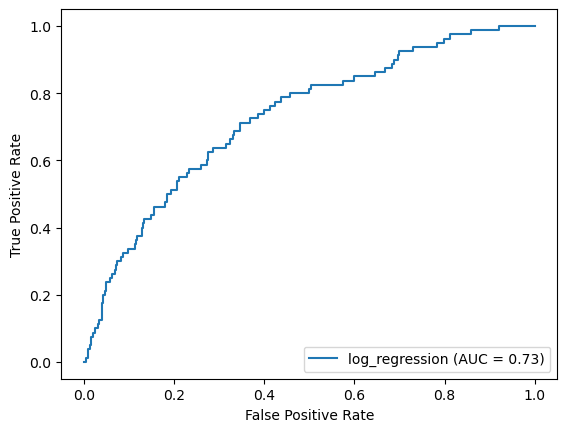

-------------------------
execution time: 5.46 seconds 



In [17]:
test_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'should_remove_outliers': True,
        'iqr_factor': 1.5,
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        'cv_splits': 5,
        'param_grid': {
            'classifier__C'      : [0.0001, 0.001, 0.01, 0.1, 1, 10], 
            'classifier__penalty': ['l1', 'l2'], 
            'classifier__solver' : ['liblinear', 'saga'],
            'classifier__class_weight' : [{0:0.25,1:1}, {0:0.5,1:1}, 'balanced']
        },
        'params': {
            'C': 0.0001,
            'penalty': 'l2',
            'solver': 'liblinear',
            'class_weight': None
        }
    }
}


train('log_regression', config=test_config, dev_mode=True)

------------ cv splits 3
AUC: 0.66
Custom: 0.58
Recall: 0.64
Precision: 0.15
F beta 10: 0.62
Accuracy: 0.68
execution time: 528.37 seconds 

Best params {'classifier__C': 0.0001, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

--------------- cv splits 5

Best params {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}

AUC: 0.67
Custom: 0.57
Recall: 0.62
Precision: 0.16
F beta 10: 0.61
Accuracy: 0.7
execution time: 711.87 seconds 

---------------- dev_mode = false


In [11]:
# debug
test_config = {
    'preprocessing': {
        'should_fill_na': False,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': False,
        'scaler': StandardScaler(),
        'should_remove_outliers': True,
        'iqr_factor': 1.5,
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        'cv_splits': 5,
        'param_grid': {
            'classifier__C'      : [0.0001, 0.001, 0.01, 0.1, 1, 10], 
            'classifier__penalty': ['l1', 'l2'], 
            'classifier__solver' : ['liblinear', 'saga'],
            'classifier__class_weight' : [{0:0.25,1:1}, {0:0.5,1:1}, 'balanced']
        },
        'params': {
            'C': 0.1,
            'penalty': 'l1',
            'solver': 'liblinear',
            'class_weight': 'balanced'
        }
    }
}

time_start = time.time()

data = process.load_data(dev_mode=True)

X = data['application'].drop(process.TARGET_COLUMN, axis=1)
y = data['application'][process.TARGET_COLUMN]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                      y,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      shuffle=False)

print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(y_train.shape))

pipeline = PIPELINES['log_regression'](config=test_config, dev_mode=True)


X_new = pipeline.fit(X_train)
X_new_test = pipeline.transform(X_test)
X_new_test.head(10)

Loading application_train ...
Loading Done.
Train shape: (4000, 121)
Valid shape: (4000,)
[Pipeline] ........... (step 1 of 4) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 4) Processing feature_extractor, total=   0.0s
-1.5
2.5
[Pipeline] ... (step 3 of 4) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 4) Processing encoder, total=   0.0s
[Pipeline] ...... (step 1 of 1) Processing preprocessor, total=   0.1s


,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",...,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,INCOME_PER_CHILD,ANNUITY_INCOME_PERC,PAYMENT_RATE,CHILDREN_RATIO
4000,1.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,...,NaN,NaN,NaN,NaN,0.2187,74250.0000,148500.0000,0.2023,0.0442,0.0000
4001,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,NaN,NaN,NaN,NaN,0.3863,78750.0000,157500.0000,0.1663,0.0642,0.0000
4002,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,...,0.0000,0.0000,3.0000,NaN,0.1117,33750.0000,67500.0000,0.3937,0.0443,0.0000
4003,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,NaN,NaN,NaN,NaN,0.3231,189000.0000,189000.0000,0.1548,0.0500,0.0000
4004,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,1.0000,0.1648,0.3686,112500.0000,225000.0000,0.0980,0.0361,0.0000
4005,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,NaN,NaN,NaN,0.4527,0.2031,37500.0000,56250.0000,0.2180,0.0443,0.3333
4006,1.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,NaN,0.1222,52500.0000,78750.0000,0.2400,0.0293,0.3333
4007,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,3.0000,NaN,0.2632,101250.0000,202500.0000,0.1118,0.0294,0.0000
4008,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,2.0000,NaN,0.4174,67500.0000,67500.0000,0.0944,0.0394,0.0000
4009,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,1.0000,0.0975,0.3924,56250.0000,112500.0000,0.1313,0.0515,0.0000


In [24]:
X_new_test['AMT_INCOME_TOTAL'].describe()

count      61503.0000
mean      168656.4206
std       113659.2270
min        26100.0000
25%       112500.0000
50%       148500.0000
75%       202500.0000
max     13500000.0000
Name: AMT_INCOME_TOTAL, dtype: float64

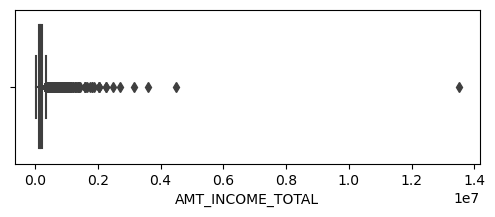

In [31]:
plt.figure(figsize=(6, 2))
sns.boxplot(data = X_new_test, x = 'AMT_INCOME_TOTAL')
plt.show()

In [12]:
X_new_test['AMT_INCOME_TOTAL'].describe()

count     1000.0000
mean    163051.1190
std      73958.6210
min      27000.0000
25%     112500.0000
50%     148500.0000
75%     202500.0000
max     337500.0000
Name: AMT_INCOME_TOTAL, dtype: float64

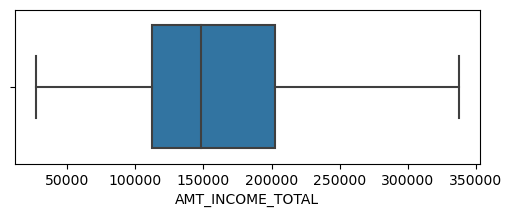

In [13]:
plt.figure(figsize=(6, 2))
sns.boxplot(data = X_new_test, x = 'AMT_INCOME_TOTAL')
plt.show()

# Experiments
## Dummy classifier

Set the baseline with the Dummy Classifier

Training the model
Loading application_train ...


2023/11/15 10:24:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '99efc56521ce44b68edbd0288454132d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2023/11/15 10:24:15 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2023/11/15 10:24:16 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/15 10:24:18 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow Data

-------------------------
ROC AUC: 0.5
Accuracy: 0.92
Fbeta score(b=10): 0.0
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.00      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

-------------------------
execution time: 8.94 seconds 



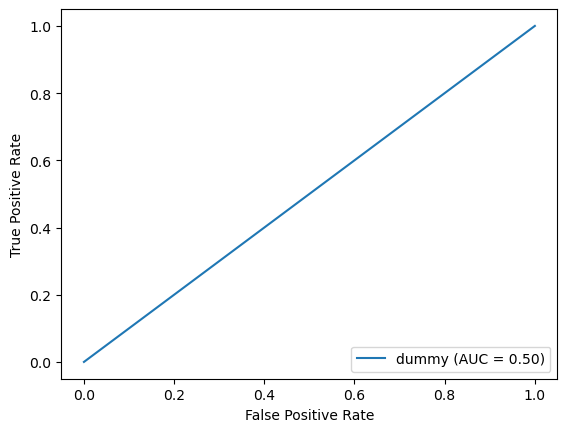

In [515]:
train('dummy', config={'strategy': 'prior'}, dev_mode=False)

TODO: explanation

## Logistic Regression

We will start with the most simple configuration.

In [16]:
# Set the experiment
mlflow.set_experiment("Logistic Regression")

# Track models automatically
mlflow.sklearn.autolog()

### Baseline

Logistic Regression with default parameters and minimum preprocessing

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2023/11/21 15:50:40 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('imputer',
                 ApplicationImputer(cat_imputer=SimpleImputer(strategy='most_frequent'),
                                    num_imputer=SimpleImputer(strategy='median'))),
                ('scalar', ApplicationScaler(scaler=StandardScaler())),
                ('encoder', ApplicationEncoder())])), ('classifier', LogisticRegress...`
2023/11/21 15:50:43 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetri

-------------------------
AUC: 0.5
Custom: 0.79
Recall: 0.0
Precision: 0.0
F beta 10: 0.0
Accuracy: 0.92
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.00      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503

-------------------------
execution time: 24.03 seconds 



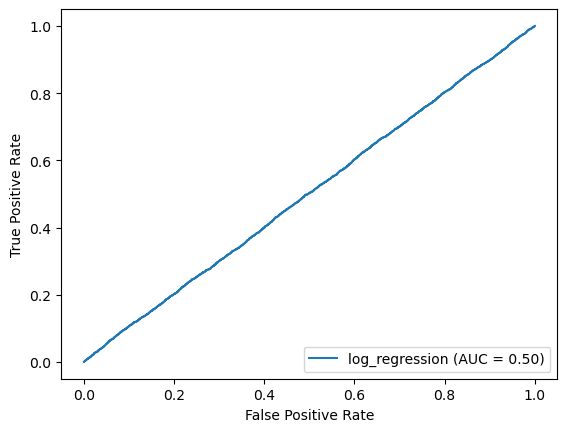

In [51]:
base_config = {
   'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'C': 1.0,
            'penalty': 'l2',
            'solver': 'lbfgs',
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'log_regression_baseline'):
    train('log_regression', config=base_config, dev_mode=False)

mlflow.end_run()

In [50]:
mlflow.end_run()

MlflowException: Run '95f4001af90942d5b71031530affd8f2' not found

### With balanced weights

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2023/11/21 15:56:28 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('imputer',
                 ApplicationImputer(cat_imputer=SimpleImputer(strategy='most_frequent'),
                                    num_imputer=SimpleImputer(strategy='median'))),
                ('scalar', ApplicationScaler(scaler=StandardScaler())),
                ('encoder', ApplicationEncoder())])), ('classifier', LogisticRegress...`
2023/11/21 15:56:30 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/21 15:56:46 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow Data

-------------------------
AUC: 0.65
Custom: 0.6
Recall: 0.59
Precision: 0.15
F beta 10: 0.58
Accuracy: 0.69
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.70      0.81     56619
           1       0.15      0.59      0.24      4884

    accuracy                           0.69     61503
   macro avg       0.55      0.65      0.52     61503
weighted avg       0.89      0.69      0.76     61503

-------------------------
execution time: 24.86 seconds 



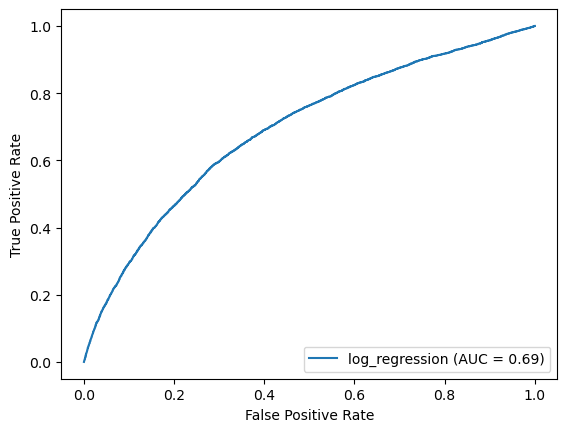

In [53]:
config_balanced = {
   'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'C': 1.0,
            'penalty': 'l2',
            'solver': 'lbfgs',
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'log_regression_balanced'):
    train('log_regression', config=config_balanced, dev_mode=False)

mlflow.end_run()

### With SMOTE

In [54]:
smote_config = {
   'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'C': 1.0,
            'penalty': 'l2',
            'solver': 'lbfgs',
            'class_weight': None
        }
    }
}

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2023/11/21 15:57:58 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/21 15:57:58 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/21 15:57:58 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/21 15:58:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

-------------------------
AUC: 0.65
Custom: 0.6
Recall: 0.59
Precision: 0.15
F beta 10: 0.58
Accuracy: 0.69
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.70      0.81     56619
           1       0.15      0.59      0.23      4884

    accuracy                           0.69     61503
   macro avg       0.55      0.65      0.52     61503
weighted avg       0.89      0.69      0.76     61503

-------------------------
execution time: 30.4 seconds 



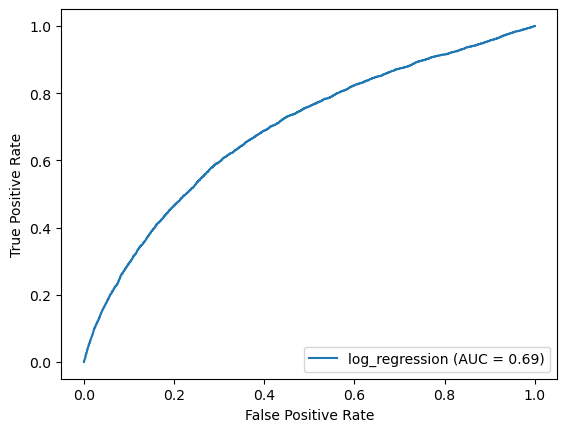

In [55]:
with mlflow.start_run(run_name = 'log_regression_smote'):
    train('log_regression', config=smote_config, dev_mode=False)

mlflow.end_run()

### With SMOTENC

In [56]:
smotenc_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': True
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'C': 1.0,
            'penalty': 'l2',
            'solver': 'lbfgs',
            'class_weight': None
        }
    }
}

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2023/11/21 16:00:00 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/21 16:00:00 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/21 16:00:00 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/21 16:03:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

-------------------------
AUC: 0.64
Custom: 0.61
Recall: 0.48
Precision: 0.16
F beta 10: 0.47
Accuracy: 0.76
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.79      0.86     56619
           1       0.16      0.48      0.25      4884

    accuracy                           0.76     61503
   macro avg       0.56      0.64      0.55     61503
weighted avg       0.88      0.76      0.81     61503

-------------------------
execution time: 219.59 seconds 



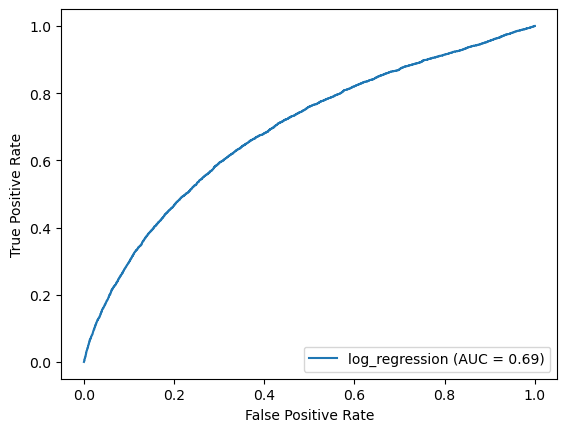

In [57]:
with mlflow.start_run(run_name = 'log_regression_base_smotenc'):
    train('log_regression', config=smotenc_config, dev_mode=False)

mlflow.end_run()

### CV best config 1

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2023/11/21 18:47:01 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/21 18:47:01 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/21 18:47:01 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/21 18:47:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

-------------------------
AUC: 0.68
Custom: 0.54
Recall: 0.66
Precision: 0.16
F beta 10: 0.64
Accuracy: 0.7
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56619
           1       0.16      0.66      0.26      4884

    accuracy                           0.70     61503
   macro avg       0.56      0.68      0.54     61503
weighted avg       0.90      0.70      0.77     61503

-------------------------
execution time: 36.98 seconds 



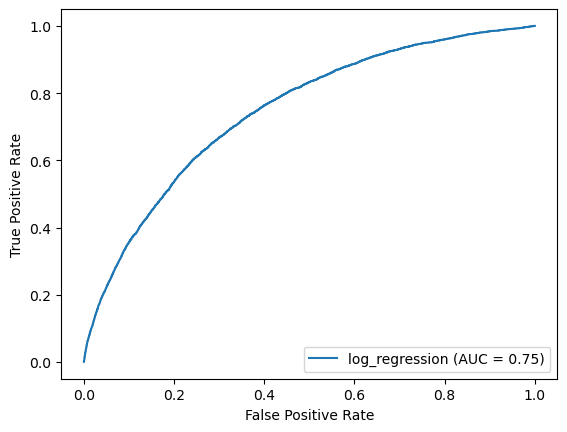

In [58]:
cv_best_config1 = {
   'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        'params': {
            'C': 0.0001,
            'penalty': 'l2',
            'solver': 'liblinear',
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'log_regression_cv_best_config1'):
    train('log_regression', config=cv_best_config1, dev_mode=False)

mlflow.end_run()

### CV best config 2

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2023/11/21 18:51:03 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/21 18:51:03 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/21 18:51:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/21 18:51:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

-------------------------
AUC: 0.69
Custom: 0.53
Recall: 0.68
Precision: 0.16
F beta 10: 0.66
Accuracy: 0.69
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56619
           1       0.16      0.68      0.26      4884

    accuracy                           0.69     61503
   macro avg       0.56      0.69      0.53     61503
weighted avg       0.90      0.69      0.76     61503

-------------------------
execution time: 343.11 seconds 



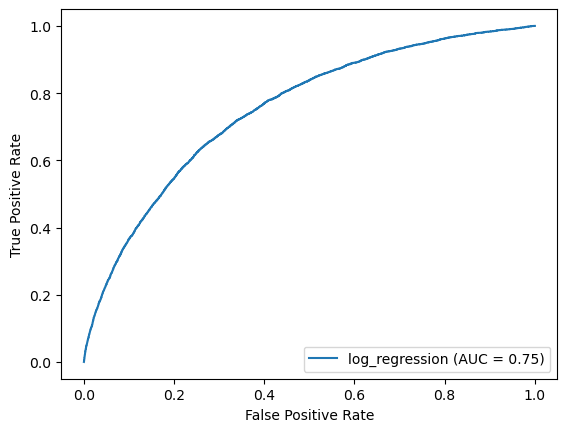

In [59]:
cv_best_config2 = {
   'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        'params': {
            'C': 0.1,
            'penalty': 'l1',
            'solver': 'liblinear',
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'log_regression_cv_best_config2'):
    train('log_regression', config=cv_best_config2, dev_mode=False)

mlflow.end_run()

### Add bureau and balance

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform
shape before  (246008, 128)
new shape after merge (246008, 244)


2023/11/21 19:30:58 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: Yaml file '/Users/natche/Jupiter/Project 7/mlruns/918128454793362263/37f0f45a5a1949eface08c07b3df1a40/inputs/8083aa324f94b7a3c8ccb94c948a275f/meta.yaml' does not exist.
2023/11/21 19:31:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing va

shape before  (61503, 128)
new shape after merge (61503, 244)


2023/11/21 19:38:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


shape before  (61503, 128)
new shape after merge (61503, 244)


2023/11/21 19:38:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
AUC: 0.69
Custom: 0.53
Recall: 0.68
Precision: 0.16
F beta 10: 0.66
Accuracy: 0.7
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     56619
           1       0.16      0.68      0.26      4884

    accuracy                           0.70     61503
   macro avg       0.56      0.69      0.54     61503
weighted avg       0.90      0.70      0.77     61503

-------------------------
execution time: 469.51 seconds 



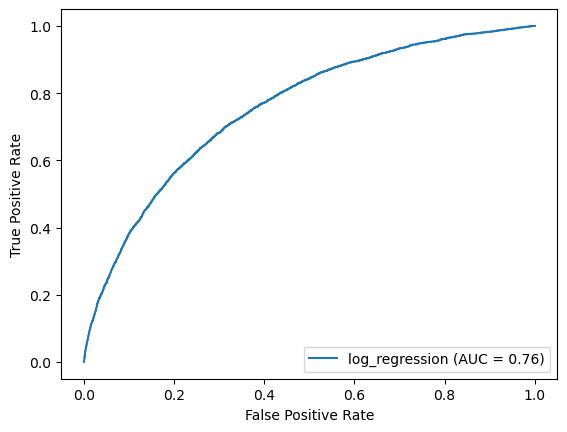

In [8]:
with_bureau_config = {
   'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'use_bureau_and_balance': True,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        'params': {
            'C': 0.1,
            'penalty': 'l1',
            'solver': 'liblinear',
            'class_weight': None
        }
    }
}


with mlflow.start_run(run_name = 'log_regression_with_bureau'):
    train('log_regression', config=with_bureau_config, dev_mode=False)
mlflow.end_run()

### Add previous applications

In [ ]:
with_prev_app_config = {
      'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        'params': {
            'C': 0.1,
            'penalty': 'l1',
            'solver': 'liblinear',
            'class_weight': None
        }
    }
}
with mlflow.start_run(run_name = 'log_regression_with_prev_app'):
    train('log_regression', config=with_prev_app_config, dev_mode=False)
mlflow.end_run()

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform
shape before  (246008, 128)
new shape after merge (246008, 244)
shape before  (246008, 244)
new shape after merge (246008, 481)


2023/11/22 10:06:28 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/22 10:06:28 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/22 10:06:28 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/22 10:06:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform
shape before  (246008, 128)
new shape after merge (246008, 244)
shape before  (246008, 244)
new shape after merge (246008, 481)


2023/11/22 10:33:59 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/22 10:33:59 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/22 10:33:59 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/22 10:34:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
2023/11/22 10:34:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: Use

shape before  (61503, 128)
new shape after merge (61503, 244)
shape before  (61503, 244)
new shape after merge (61503, 481)


2023/11/22 10:35:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


shape before  (61503, 128)
new shape after merge (61503, 244)
shape before  (61503, 244)
new shape after merge (61503, 481)


2023/11/22 10:35:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
AUC: 0.7
Custom: 0.51
Recall: 0.68
Precision: 0.17
F beta 10: 0.66
Accuracy: 0.71
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.72      0.82     56619
           1       0.17      0.68      0.27      4884

    accuracy                           0.71     61503
   macro avg       0.57      0.70      0.55     61503
weighted avg       0.90      0.71      0.78     61503

-------------------------
execution time: 114.76 seconds 



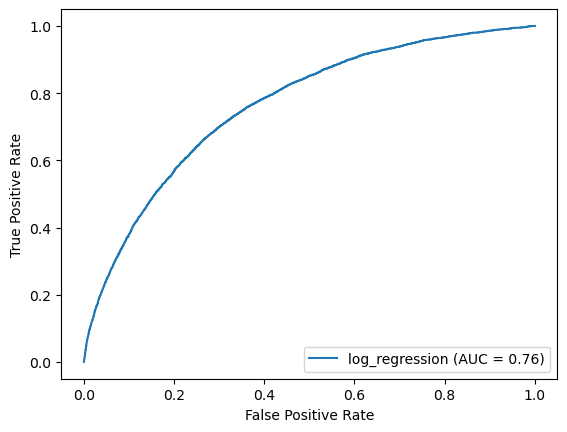

In [9]:
with_prev_app_config1 = {
      'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        'params': {
            'C': 0.0001,
            'penalty': 'l2',
            'solver': 'liblinear',
            'class_weight': None
        }
    }
}
with mlflow.start_run(run_name = 'log_regression_with_prev_app1'):
    train('log_regression', config=with_prev_app_config1, dev_mode=False)
mlflow.end_run()

### Add POS CASH balance

In [10]:
with_pos_cash_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        'params': {
            'C': 0.0001,
            'penalty': 'l2',
            'solver': 'liblinear',
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'log_regression_with_pos_cash'):
    train('log_regression', config=with_pos_cash_config, dev_mode=False)
mlflow.end_run()

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform
shape before  (246008, 128)
new shape after merge (246008, 244)
shape before  (246008, 244)
new shape after merge (246008, 481)
shape before  (246008, 481)
new shape after merge (246008, 499)


2023/11/22 10:37:53 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/22 10:37:53 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/22 10:37:53 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/22 10:38:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

shape before  (61503, 128)
new shape after merge (61503, 244)
shape before  (61503, 244)
new shape after merge (61503, 481)
shape before  (61503, 481)
new shape after merge (61503, 499)


2023/11/22 10:39:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


shape before  (61503, 128)
new shape after merge (61503, 244)
shape before  (61503, 244)
new shape after merge (61503, 481)
shape before  (61503, 481)
new shape after merge (61503, 499)


2023/11/22 10:39:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
AUC: 0.7
Custom: 0.51
Recall: 0.68
Precision: 0.17
F beta 10: 0.66
Accuracy: 0.71
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.72      0.82     56619
           1       0.17      0.68      0.28      4884

    accuracy                           0.71     61503
   macro avg       0.57      0.70      0.55     61503
weighted avg       0.90      0.71      0.78     61503

-------------------------
execution time: 120.08 seconds 



### Add installments payments

In [11]:
with_installments_config = {
      'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        'params': {
            'C': 0.0001,
            'penalty': 'l2',
            'solver': 'liblinear',
            'class_weight': None
        }
    }
}
with mlflow.start_run(run_name = 'log_regression_with_installments'):
    train('log_regression', config=with_installments_config, dev_mode=False)
mlflow.end_run()

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform
shape before  (246008, 128)
new shape after merge (246008, 244)
shape before  (246008, 244)
new shape after merge (246008, 481)
shape before  (246008, 481)
new shape after merge (246008, 499)
shape before  (246008, 499)
new shape after merge (246008, 521)


2023/11/22 10:41:29 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/22 10:41:29 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/22 10:41:29 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/22 10:42:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

shape before  (61503, 128)
new shape after merge (61503, 244)
shape before  (61503, 244)
new shape after merge (61503, 481)
shape before  (61503, 481)
new shape after merge (61503, 499)
shape before  (61503, 499)
new shape after merge (61503, 521)


2023/11/22 10:42:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


shape before  (61503, 128)
new shape after merge (61503, 244)
shape before  (61503, 244)
new shape after merge (61503, 481)
shape before  (61503, 481)
new shape after merge (61503, 499)
shape before  (61503, 499)
new shape after merge (61503, 521)


2023/11/22 10:42:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
AUC: 0.7
Custom: 0.51
Recall: 0.69
Precision: 0.17
F beta 10: 0.67
Accuracy: 0.72
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.72      0.82     56619
           1       0.17      0.69      0.28      4884

    accuracy                           0.72     61503
   macro avg       0.57      0.70      0.55     61503
weighted avg       0.90      0.72      0.78     61503

-------------------------
execution time: 137.66 seconds 



### Add credit card balance

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform
shape before  (246008, 128)
new shape after merge (246008, 244)
shape before  (246008, 244)
new shape after merge (246008, 481)
shape before  (246008, 481)
new shape after merge (246008, 499)
shape before  (246008, 499)
new shape after merge (246008, 521)
shape before  (246008, 521)
new shape after merge (246008, 662)


2023/11/22 10:53:07 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/22 10:53:07 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/22 10:53:07 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/22 10:53:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

shape before  (61503, 128)
new shape after merge (61503, 244)
shape before  (61503, 244)
new shape after merge (61503, 481)
shape before  (61503, 481)
new shape after merge (61503, 499)
shape before  (61503, 499)
new shape after merge (61503, 521)
shape before  (61503, 521)
new shape after merge (61503, 662)


2023/11/22 10:54:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


shape before  (61503, 128)
new shape after merge (61503, 244)
shape before  (61503, 244)
new shape after merge (61503, 481)
shape before  (61503, 481)
new shape after merge (61503, 499)
shape before  (61503, 499)
new shape after merge (61503, 521)
shape before  (61503, 521)
new shape after merge (61503, 662)


2023/11/22 10:54:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
AUC: 0.7
Custom: 0.51
Recall: 0.69
Precision: 0.17
F beta 10: 0.67
Accuracy: 0.72
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.72      0.82     56619
           1       0.17      0.69      0.28      4884

    accuracy                           0.72     61503
   macro avg       0.57      0.70      0.55     61503
weighted avg       0.90      0.72      0.78     61503



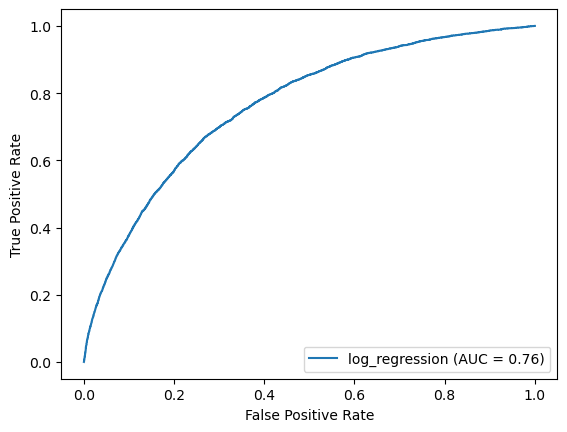

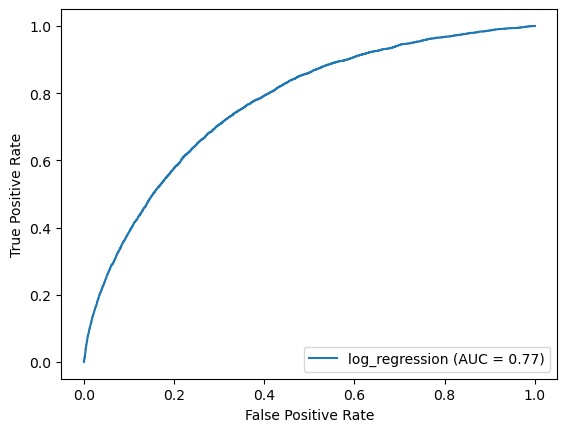

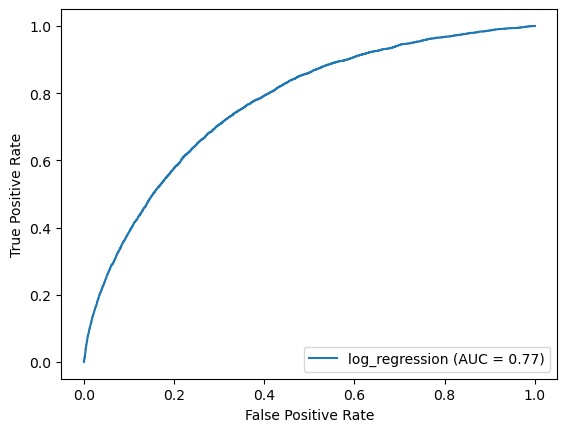

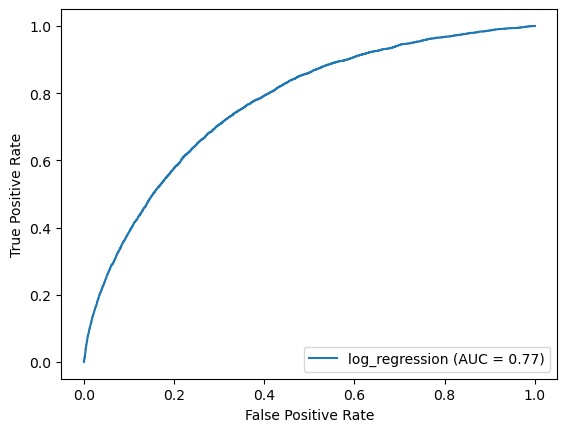

-------------------------
execution time: 147.19 seconds 



In [15]:
with_cc_balance_config = {
      'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        'params': {
            'C': 0.0001,
            'penalty': 'l2',
            'solver': 'liblinear',
            'class_weight': None
        }
    }
}
with mlflow.start_run(run_name = 'log_regression_with_cc_balance'):
    train('log_regression', config=with_cc_balance_config, dev_mode=False)
mlflow.end_run()

### With MinMaxScaler

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform
shape before  (246008, 128)
new shape after merge (246008, 244)
shape before  (246008, 244)
new shape after merge (246008, 481)
shape before  (246008, 481)
new shape after merge (246008, 499)
shape before  (246008, 499)
new shape after merge (246008, 521)
shape before  (246008, 521)
new shape after merge (246008, 662)


2023/11/22 11:08:03 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/22 11:08:03 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/22 11:08:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/22 11:08:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

shape before  (61503, 128)
new shape after merge (61503, 244)
shape before  (61503, 244)
new shape after merge (61503, 481)
shape before  (61503, 481)
new shape after merge (61503, 499)
shape before  (61503, 499)
new shape after merge (61503, 521)
shape before  (61503, 521)
new shape after merge (61503, 662)


2023/11/22 11:09:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


shape before  (61503, 128)
new shape after merge (61503, 244)
shape before  (61503, 244)
new shape after merge (61503, 481)
shape before  (61503, 481)
new shape after merge (61503, 499)
shape before  (61503, 499)
new shape after merge (61503, 521)
shape before  (61503, 521)
new shape after merge (61503, 662)


2023/11/22 11:09:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


-------------------------
AUC: 0.68
Custom: 0.55
Recall: 0.67
Precision: 0.15
F beta 10: 0.65
Accuracy: 0.68
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     56619
           1       0.15      0.67      0.25      4884

    accuracy                           0.68     61503
   macro avg       0.56      0.68      0.52     61503
weighted avg       0.90      0.68      0.75     61503



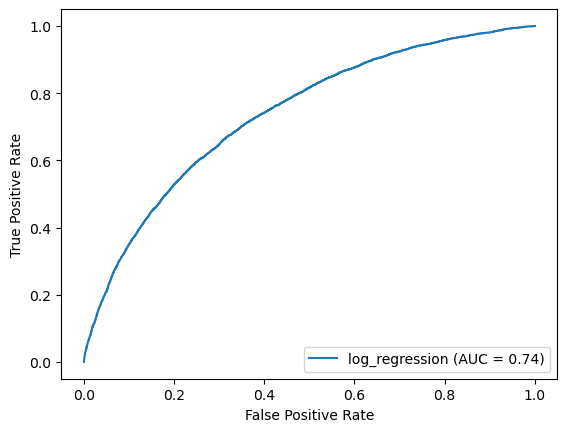

-------------------------
execution time: 130.4 seconds 



In [17]:
with_min_max_scaler_config = {
      'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': MinMaxScaler(),
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        'params': {
            'C': 0.0001,
            'penalty': 'l2',
            'solver': 'liblinear',
            'class_weight': None
        }
    }
}
with mlflow.start_run(run_name = 'log_regression_minmax_scaler'):
    train('log_regression', config=with_min_max_scaler_config, dev_mode=False)
mlflow.end_run()

### Without outliers

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2023/11/22 16:37:03 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/22 16:37:03 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/22 16:37:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/22 16:37:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

-------------------------
AUC: 0.7
Custom: 0.51
Recall: 0.69
Precision: 0.17
F beta 10: 0.67
Accuracy: 0.71
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.72      0.82     56619
           1       0.17      0.69      0.28      4884

    accuracy                           0.71     61503
   macro avg       0.57      0.70      0.55     61503
weighted avg       0.90      0.71      0.78     61503



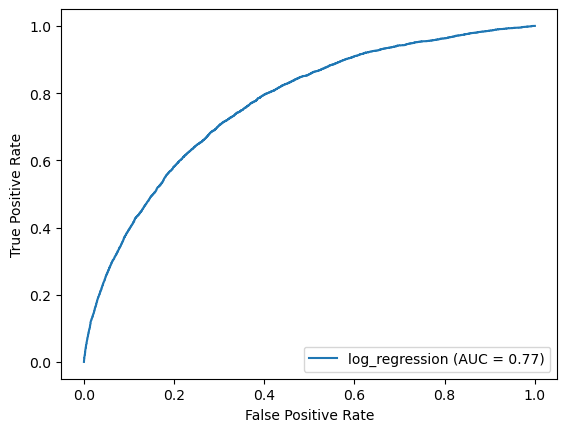

-------------------------
execution time: 153.25 seconds 



In [22]:
without_outliers_config = {
      'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'should_remove_outliers': True,
        'iqr_factor': 1.5,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        'params': {
            'C': 0.0001,
            'penalty': 'l2',
            'solver': 'liblinear',
            'class_weight': None
        }
    }
}
with mlflow.start_run(run_name = 'log_regression_without_outliers'):
    train('log_regression', config=without_outliers_config, dev_mode=False)
mlflow.end_run()

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2023/11/22 16:42:09 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/22 16:42:09 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/22 16:42:09 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/22 16:42:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

-------------------------
AUC: 0.7
Custom: 0.51
Recall: 0.69
Precision: 0.17
F beta 10: 0.67
Accuracy: 0.71
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     56619
           1       0.17      0.69      0.27      4884

    accuracy                           0.71     61503
   macro avg       0.57      0.70      0.55     61503
weighted avg       0.90      0.71      0.78     61503



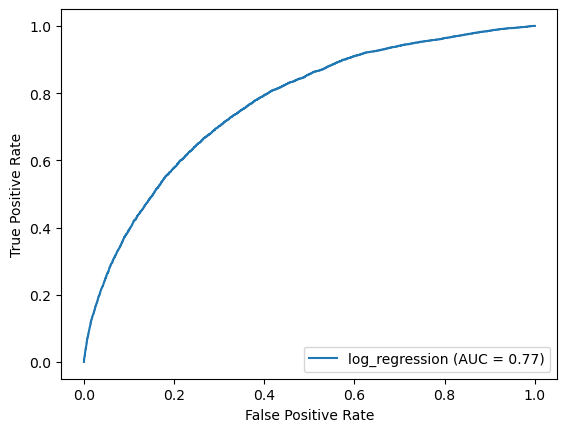

-------------------------
execution time: 151.47 seconds 



In [23]:
without_outliers_config2 = {
      'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'should_remove_outliers': True,
        'iqr_factor': 2.5,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        'params': {
            'C': 0.0001,
            'penalty': 'l2',
            'solver': 'liblinear',
            'class_weight': None
        }
    }
}
with mlflow.start_run(run_name = 'log_regression_without_outliers_2'):
    train('log_regression', config=without_outliers_config2, dev_mode=False)
mlflow.end_run()

## RandomForestClassifier

In [25]:
# Set the experiment
mlflow.set_experiment("Random Forest Classifier")

# Track models automatically
mlflow.sklearn.autolog()

2023/11/22 18:34:28 INFO mlflow.tracking.fluent: Experiment with name 'Random Forest Classifier' does not exist. Creating a new experiment.


### Baseline

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2023/11/22 18:37:18 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('imputer',
                 ApplicationImputer(cat_imputer=SimpleImputer(strategy='most_frequent'),
                                    num_imputer=SimpleImputer(strategy='median'))),
                ('scalar', ApplicationScaler(scaler=StandardScaler())),
                ('encoder', ApplicationEncoder())])), ('classifier', RandomForestCla...`
2023/11/22 18:37:21 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/22 18:39:18 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow Data

-------------------------
AUC: 0.5
Custom: 0.79
Recall: 0.0
Precision: 0.43
F beta 10: 0.0
Accuracy: 0.92
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.43      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.67      0.50      0.48     61503
weighted avg       0.88      0.92      0.88     61503



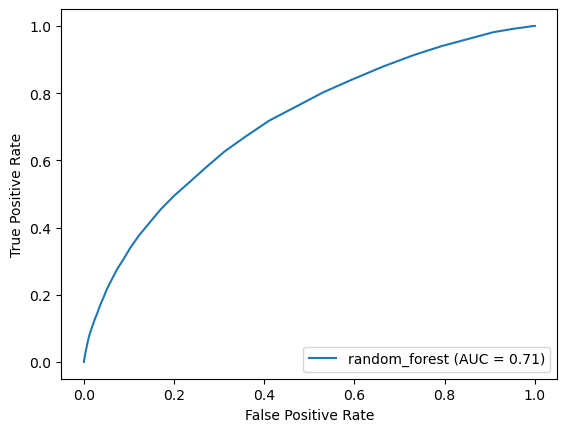

-------------------------
execution time: 129.19 seconds 



In [28]:
base_config = {
   'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 2.5,
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'criterion': 'gini',
            'max_features': 'sqrt',
            'max_depth': None,
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'random_forest_baseline'):
    train('random_forest', config=base_config, dev_mode=False)

mlflow.end_run()

### Balancing

**SMOTE**

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2023/11/22 18:43:47 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/22 18:43:47 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/22 18:43:47 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/22 18:44:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

-------------------------
AUC: 0.5
Custom: 0.79
Recall: 0.0
Precision: 0.5
F beta 10: 0.0
Accuracy: 0.92
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.50      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.71      0.50      0.48     61503
weighted avg       0.89      0.92      0.88     61503



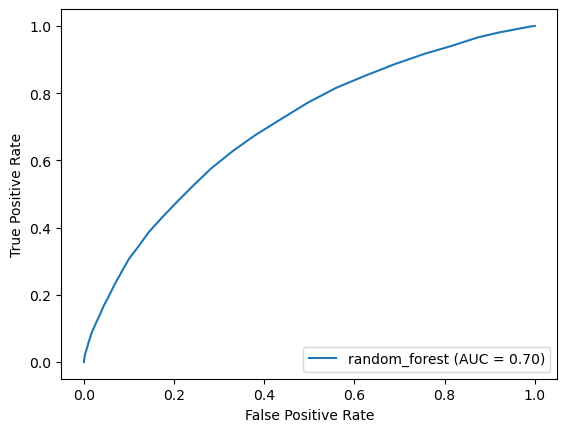

-------------------------
execution time: 216.07 seconds 



In [29]:
with_smote_config = {
   'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'criterion': 'gini',
            'max_features': 'sqrt',
            'max_depth': None,
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'random_forest_smote'):
    train('random_forest', config=with_smote_config, dev_mode=False)

mlflow.end_run()

**SMOTE NC**

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2023/11/22 18:49:43 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/22 18:49:43 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/22 18:49:43 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/22 18:52:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

-------------------------
AUC: 0.5
Custom: 0.79
Recall: 0.0
Precision: 0.25
F beta 10: 0.0
Accuracy: 0.92
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.25      0.00      0.01      4884

    accuracy                           0.92     61503
   macro avg       0.58      0.50      0.48     61503
weighted avg       0.87      0.92      0.88     61503



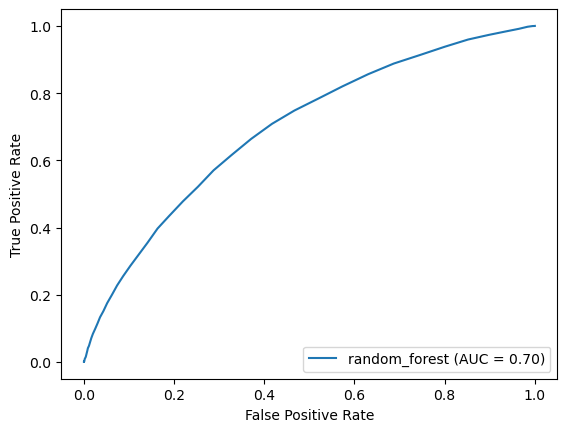

-------------------------
execution time: 396.1 seconds 



In [30]:
with_smotenc_config = {
   'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': True
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'criterion': 'gini',
            'max_features': 'sqrt',
            'max_depth': None,
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'random_forest_smotenc'):
    train('random_forest', config=with_smotenc_config, dev_mode=False)

mlflow.end_run()

**Class weight**

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2023/11/22 18:57:27 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('imputer',
                 ApplicationImputer(cat_imputer=SimpleImputer(strategy='most_frequent'),
                                    num_imputer=SimpleImputer(strategy='median'))),
                ('scalar', ApplicationScaler(scaler=StandardScaler())),
                ('encoder', ApplicationEncoder())])), ('classifier', RandomForestCla...`
2023/11/22 18:57:30 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/22 18:59:12 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow Data

-------------------------
AUC: 0.5
Custom: 0.79
Recall: 0.0
Precision: 0.0
F beta 10: 0.0
Accuracy: 0.92
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.00      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


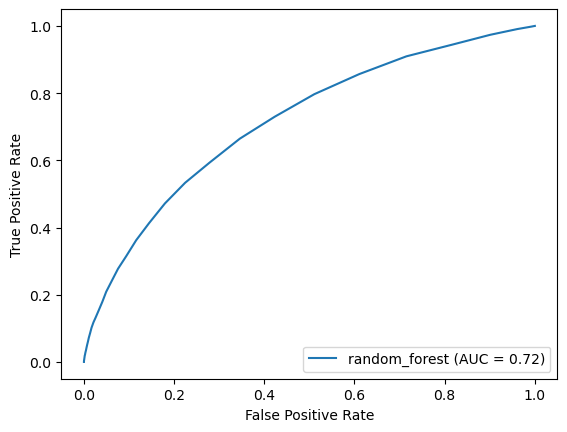

-------------------------
execution time: 114.19 seconds 



In [31]:
with_weights_config = {
   'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'should_remove_outliers': False,
        'iqr_factor': 1.5,
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'criterion': 'gini',
            'max_features': 'sqrt',
            'max_depth': None,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'random_forest_class_weights'):
    train('random_forest', config=with_weights_config, dev_mode=False)

mlflow.end_run()

### Without outliers

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2023/11/22 19:04:00 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/11/22 19:04:00 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2023/11/22 19:04:00 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2023/11/22 19:04:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement er

-------------------------
AUC: 0.5
Custom: 0.79
Recall: 0.0
Precision: 0.75
F beta 10: 0.0
Accuracy: 0.92
Classification report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56619
           1       0.75      0.00      0.00      4884

    accuracy                           0.92     61503
   macro avg       0.84      0.50      0.48     61503
weighted avg       0.91      0.92      0.88     61503



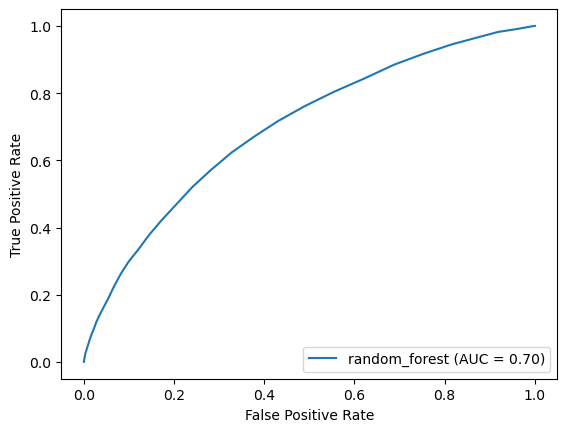

-------------------------
execution time: 210.87 seconds 



In [32]:
without_outliers_config = {
   'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'should_remove_outliers': True,
        'iqr_factor': 1.5,
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': True,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        # default
        'params': {
            'n_estimators': 100,
            'criterion': 'gini',
            'max_features': 'sqrt',
            'max_depth': None,
            'class_weight': None
        }
    }
}

with mlflow.start_run(run_name = 'random_forest_without_outliers'):
    train('random_forest', config=without_outliers_config, dev_mode=False)

mlflow.end_run()

### GridSearchCV on sample

2023/11/22 19:08:46 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cleaner', ApplicationCleaner()),
                                 ('feature_extractor',
                                  ApplicationFeaturesExtractor()),
                                 ('outlier_remover', OutlierRemover()),
                                 ('imputer',
                                  ApplicationImputer(cat_imputer=SimpleImputer(strategy='most_frequent'),
                                                   ...`


Training the model
Loading application_train ...
Loading Done.
Train shape: (8000, 121)
Valid shape: (8000,)
Start pipeline fit and transform


2023/11/22 19:08:46 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1749.625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/J

[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.1s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.1s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipel

/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2325.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_b

[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.1s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.4s
[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.0s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipel

upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1627.625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast

[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.1s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.1s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipel

/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1744.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2345.625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.

[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.1s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.4s
[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.1s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipel

/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1749.625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2256.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.u

[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.1s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.4s
[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.1s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipel

/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1749.625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2256.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.u

[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.1s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.1s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipel

/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1749.625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2256.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.u

[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.1s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.1s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipel

/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1744.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2345.625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.

[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.0s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.2s
[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.0s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipel

/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1749.625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2256.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.u

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.3s
[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.1s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.5s
[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipel

/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1749.625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2256.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.u

[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.0s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.1s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipel

/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1749.625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2256.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.u

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.8s
[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.1s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.6s
[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipel

/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2325.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_b

[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.2s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.1s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.5s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.6s
[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.1s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.1s
[Pipel

/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2325.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_b

[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.0s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.1s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.4s
[Pipel

/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1627.625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper

[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.0s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.1s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipel

/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1744.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2345.625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.4s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.6s
[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.1s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.1s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.1s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.5s
[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.0s
[Pipel

/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1558.125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.upper_bounds[feature], feature] = self.upper_bounds[feature]
/Users/natche/Jupiter/Project 7/transformers.py:180: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2225.625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[X[feature] > self.

[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.0s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   1.0s


2023/11/22 19:10:20 WARNING mlflow.sklearn: Failed to infer model signature: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
2023/11/22 19:10:23 INFO mlflow.sklearn.utils: Logging the 5 best runs, 157 runs will be omitted.
2023/11/22 19:10:23 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('outlier_remover', OutlierRemover()),
                ('imputer',
                 ApplicationImputer(cat_imputer=SimpleImputer(strategy='most_frequent'),
                                    num_imputer=SimpleImputer(strategy='median'))),
                ('scalar', ApplicationScaler(scaler=StandardScaler())),
                ('encoder', A...`
2023/11/22 19:10:23 WARNING mlflow.utils: Truncated th

Best params {'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 300}


2023/11/22 19:10:23 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).


-------------------------
AUC: 0.66
Custom: 0.58
Recall: 0.6
Precision: 0.15
F beta 10: 0.58
Accuracy: 0.71
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.71      0.82      1843
           1       0.15      0.60      0.24       157

    accuracy                           0.71      2000
   macro avg       0.55      0.66      0.53      2000
weighted avg       0.89      0.71      0.77      2000



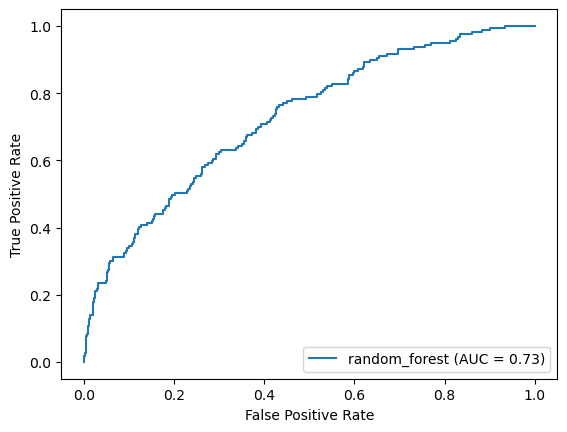

-------------------------
execution time: 97.77 seconds 

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.9s
[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.1s
[Pipeline] ............ (step 5 of 6) Processing scalar, total=   0.1s
[Pipeline] ........... (step 6 of 6) Processing encoder, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.3s
[Pipeline] ........... (step 1 of 6) Processing cleaner, total=   0.0s
[Pipeline] . (step 2 of 6) Processing feature_extractor, total=   0.0s
[Pipeline] ... (step 3 of 6) Processing outlier_remover, total=   0.1s
[Pipeline] ........

In [34]:
test_cv_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'should_remove_outliers': True,
        'iqr_factor': 1.5,
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': True,
        'cv_splits': 5,
        'param_grid': {
            'classifier__n_estimators': [100, 200, 300], 
            'classifier__criterion': ['gini', 'entropy'], 
            'classifier__max_features' : ['auto', 'sqrt', 'log2'],
            'classifier__max_depth' : [3, 5, 8],
            'classifier__class_weight' : [{0:0.25,1:1}, {0:0.5,1:1}, 'balanced']
        },
        'params': {
            'n_estimators': 100,
            'criterion': 'gini',
            'max_features': 'sqrt',
            'max_depth': None,
            'class_weight': None
        }
    }
}

train('random_forest', config=test_cv_config, dev_mode=True)


### CV best config

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2023/11/22 19:17:43 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('outlier_remover', OutlierRemover()),
                ('imputer',
                 ApplicationImputer(cat_imputer=SimpleImputer(strategy='most_frequent'),
                                    num_imputer=SimpleImputer(strategy='median'))),
                ('scalar', ApplicationScaler(scaler=StandardScaler())),
                ('encoder', A...`
2023/11/22 19:17:43 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('outlier_remover', OutlierRemover()),
                ('imputer',
                 ApplicationImputer(cat_imputer=SimpleImputer(strategy='most_frequent'

-------------------------
AUC: 0.66
Custom: 0.59
Recall: 0.65
Precision: 0.14
F beta 10: 0.63
Accuracy: 0.66
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.66      0.78     56619
           1       0.14      0.65      0.23      4884

    accuracy                           0.66     61503
   macro avg       0.55      0.66      0.51     61503
weighted avg       0.89      0.66      0.74     61503



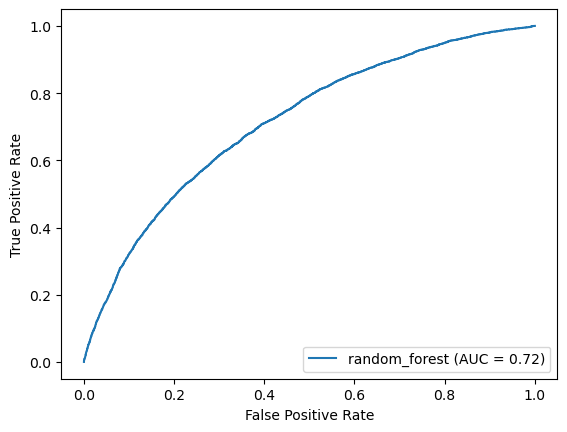

-------------------------
execution time: 66.14 seconds 



In [37]:
cv_best_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'should_remove_outliers': True,
        'iqr_factor': 1.5,
        'use_bureau_and_balance': False,
        'use_previous_applications': False,
        'use_pos_cash_balance': False,
        'use_installments_payments': False,
        'use_credit_card_balance': False,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        'params': {
            'n_estimators': 300,
            'criterion': 'gini',
            'max_features': 'sqrt',
            'max_depth': 3,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'random_forest_cv_best_config'):
    train('random_forest', config=cv_best_config, dev_mode=False)

mlflow.end_run()


### All datasets

Training the model
Loading application_train ...
Loading Done.
Train shape: (246008, 121)
Valid shape: (246008,)
Start pipeline fit and transform


2023/11/22 19:21:15 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
SK_ID_CURR                                                   
100001                       -1572                     -49   
100002                       -1437                    -103   
100...`
2023/11/22 19:21:16 WARNING mlflow.utils: Truncated the value of the key `preprocessor`. Truncated value: `Pipeline(steps=[('cleaner', ApplicationCleaner()),
                ('feature_extractor', ApplicationFeaturesExtractor()),
                ('merge_bureau_and_balance',
                 ApplicationFeaturesMerger(features_to_merge=            BUREAU_DAYS_CREDIT_MIN  BUREAU_DAYS_CREDIT_MAX  \
S

-------------------------
AUC: 0.65
Custom: 0.6
Recall: 0.66
Precision: 0.14
F beta 10: 0.64
Accuracy: 0.64
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.64      0.77     56619
           1       0.14      0.66      0.23      4884

    accuracy                           0.64     61503
   macro avg       0.55      0.65      0.50     61503
weighted avg       0.89      0.64      0.73     61503



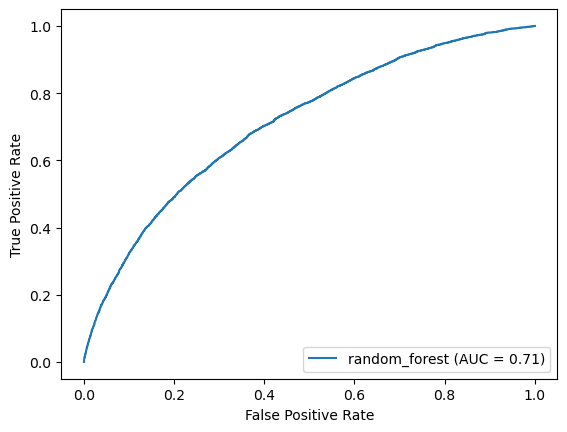

-------------------------
execution time: 203.39 seconds 



In [38]:
all_datasets_config = {
    'preprocessing': {
        'should_fill_na': True,
        'num_imputer': SimpleImputer(strategy='median'),
        'cat_imputer': SimpleImputer(strategy='most_frequent'),
        'should_scale': True,
        'scaler': StandardScaler(),
        'should_remove_outliers': True,
        'iqr_factor': 1.5,
        'use_bureau_and_balance': True,
        'use_previous_applications': True,
        'use_pos_cash_balance': True,
        'use_installments_payments': True,
        'use_credit_card_balance': True,
    },
     'balancing': {
        'should_oversample': False,
        'with_categorical': False
    },
    'model_params': {
        'random_state': 42,
        'use_cv': False,
        'params': {
            'n_estimators': 300,
            'criterion': 'gini',
            'max_features': 'sqrt',
            'max_depth': 3,
            'class_weight': 'balanced'
        }
    }
}

with mlflow.start_run(run_name = 'random_forest_all_datasets'):
    train('random_forest', config=all_datasets_config, dev_mode=False)

mlflow.end_run()